In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

In [ ]:
def load_and_filter_data(file_path, courier_id, day_id):
    try:
        df = pd.read_csv(file_path)
        filtered_df = df[(df.courier_id == courier_id) & (df.ds == day_id)]
        if filtered_df.empty:
            print(f"No data for courier {courier_id} on day {day_id}.")
            return None
        return filtered_df[['lat', 'lng']].values
    except FileNotFoundError:
        print(f"Error: Dataset not found at {file_path}.")
        return None

def calculate_distance_matrix(points):
    """
    Calculates the pairwise Euclidean distance matrix for a set of points.
    
    Args:
        points (numpy.ndarray): An array of shape (n_points, n_dimensions) representing the coordinates of each point.
    
    Returns:
        numpy.ndarray: A symmetric (n_points, n_points) array where the entry at [i, j] contains the Euclidean distance between points i and j.
    """
    n_points = len(points)
    distances = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(i + 1, n_points):
            # calculates the L2 norm, which is also known as the Euclidean norm
            dist = np.linalg.norm(points[i] - points[j])
            # chained assignment only needs to compute the distance between i and j once,
            # store it in dist, and then populate both positions in the matrix.
            distances[i, j] = distances[j, i] = dist
    return distances

def run_aco_with_history(distances, n_ants, n_iterations, decay, alpha, beta):
    """
    Runs the Ant Colony Optimization (ACO) algorithm for the Traveling Salesman Problem (TSP)
    and records the best distance found at each iteration.

    Args:
        distances (numpy.ndarray): A 2D array representing the pairwise distance matrix between points.
            # Each entry distances[i, j] is the Euclidean distance between node i and node j.
        n_ants (int): Number of ants (candidate solutions) used in each iteration.
            # More ants increase exploration but require more computation per iteration.
        n_iterations (int): Number of iterations to run the ACO algorithm.
            # More iterations allow for more refinement but increase total runtime.
        decay (float): Pheromone evaporation rate (between 0 and 1).
            # Each iteration, pheromone *= decay. Lower values mean faster evaporation, encouraging exploration.
        alpha (float): Relative importance of pheromone strength in path selection.
            # In probability calculation, pheromone^alpha. Higher alpha means ants follow pheromone trails more closely.
        beta (float): Relative importance of heuristic information (inverse distance) in path selection.
            # In probability calculation, (1/distance)^beta. Higher beta means ants prefer shorter edges more strongly.

    Returns:
        tuple:
            best_path (list): The sequence of point indices representing the shortest route found.
            best_path_distance (float): The total distance of the best_path.
            distance_history (list): List of the best path distance found at each iteration (for convergence visualization).
    """
    n_points = len(distances)
    pheromone = np.ones((n_points, n_points))  # Initial pheromone level on all edges
    best_path = None
    best_path_distance = np.inf
    distance_history = []  # To store best distance per iteration

    for i in range(n_iterations):
        all_paths = []
        for _ in range(n_ants):
            path = [np.random.randint(n_points)]  # Start at a random node
            visited = set(path)
            while len(visited) < n_points:
                current_node = path[-1]
                # Calculate probabilities for the next move:
                pheromone_levels = np.copy(pheromone[current_node])
                pheromone_levels[list(visited)] = 0  # Don't revisit nodes
                heuristic_values = 1.0 / (distances[current_node] + 1e-10)  # Inverse distance (avoid division by zero)
                # Probability ∝ (pheromone^alpha) * (heuristic^beta)
                move_probabilities = (pheromone_levels ** alpha) * (heuristic_values ** beta)
                sum_probs = np.sum(move_probabilities)
                if sum_probs == 0:
                    # If all probabilities are zero, pick randomly among unvisited
                    unvisited = list(set(range(n_points)) - visited)
                    next_node = np.random.choice(unvisited)
                else:
                    move_probabilities /= sum_probs  # Normalize to sum to 1
                    next_node = np.random.choice(range(n_points), p=move_probabilities)
                path.append(next_node)
                visited.add(next_node)

            # Calculate total distance of the path (including return to start)
            current_distance = 0
            for j in range(n_points - 1):
                current_distance += distances[path[j], path[j+1]]
            current_distance += distances[path[-1], path[0]]  # Complete the tour
            all_paths.append((path, current_distance))

        # Pheromone evaporation: reduce all pheromones by decay factor
        pheromone *= decay
        # Deposit pheromone: reinforce edges used in each ant's path, inversely proportional to path length
        for path, dist in all_paths:
            for j in range(n_points - 1):
                pheromone[path[j], path[j+1]] += 1.0 / dist
            pheromone[path[-1], path[0]] += 1.0 / dist

        # Track the best path found so far
        current_shortest_path, current_min_distance = min(all_paths, key=lambda x: x[1])
        if current_min_distance < best_path_distance:
            best_path = current_shortest_path
            best_path_distance = current_min_distance

        distance_history.append(best_path_distance)  # Save best distance for this iteration
    return best_path, best_path_distance, distance_history

def perform_grid_search(distances):
    """
    Performs a grid search over a predefined parameter space to find the
    best hyperparameters for the ACO algorithm.
    """
    # Define the parameter grid. Adjust these values based on your needs.
    # Keep the number of combinations low initially to ensure it runs quickly.
    param_grid = {
        'n_ants': [10, 20],
        'n_iterations': [50, 100],
        'decay': [0.9, 0.95],
        'alpha': [1, 2],
        'beta': [1, 2, 3]
    }

    # Generate all combinations of parameters
    params_list = list(product(
        param_grid['n_ants'],
        param_grid['n_iterations'],
        param_grid['decay'],
        param_grid['alpha'],
        param_grid['beta']
    ))
    
    results = []
    print(f"Starting grid search with {len(params_list)} combinations...")

    for i, params in enumerate(params_list):
        n_ants, n_iterations, decay, alpha, beta = params
        # We only need the final distance for scoring, so we can use a simpler runner
        _, best_dist, _ = run_aco_with_history(
            distances, n_ants, n_iterations, decay, alpha, beta
        )
        results.append({
            'params': {
                'n_ants': n_ants, 'n_iterations': n_iterations, 'decay': decay,
                'alpha': alpha, 'beta': beta
            },
            'distance': best_dist
        })
        print(f"  ({i+1}/{len(params_list)}) Completed. Distance: {best_dist:.4f}")

    # Score the results by finding the combination with the minimum distance
    best_result = min(results, key=lambda x: x['distance'])
    return best_result, results

def plot_convergence(distance_history):
    """
    Plots the best distance found at each iteration of a single ACO run.
    This shows how the algorithm converges to a solution.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(distance_history, marker='o', linestyle='-', markersize=4)
    plt.title('ACO Convergence Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Best Distance Found')
    plt.grid(True)
    plt.show()


def plot_route_plotly(points, best_path):
    """
    Plots the final, optimized route on an interactive 2D scatter plot using Plotly.
    Hover data shows the route order like Depot -> 1 -> 2 -> ... -> N -> Depot.
    
    Args:
        points (numpy.array): An array of all coordinates, with the depot at index 0.
        best_path (list): A list of indices representing the optimized route.
    """
    # The ACO algorithm might return a valid tour that doesn't start at the depot.
    # We rotate the path list to ensure it begins with index 0.
    if best_path[0] != 0:
        depot_start_index = best_path.index(0)
        best_path = best_path[depot_start_index:] + best_path[:depot_start_index]

    # Create the full path for plotting, including the return to the depot.
    path_order = best_path + [best_path[0]]
    ordered_points = points[path_order]
    
    hover_texts = []
    for i, point_index in enumerate(path_order):
        if i == 0:
            hover_texts.append("Depot (Start)")
        elif i == len(path_order) - 1:
            # This is the final point, the return to the depot.
            hover_texts.append("Return to Depot")
        else:
            # The original code used i+1, causing an off-by-one error.
            # Using 'i' provides the correct 1-based stop number (Stop 1, Stop 2, etc.).
            hover_texts.append(f"Delivery Stop {i}")
            
    # Initialize the Plotly figure.
    fig = go.Figure()
    
    # Add the main route trace (lines and markers).
    fig.add_trace(go.Scatter(
        x=ordered_points[:, 1],  # Longitude
        y=ordered_points[:, 0],  # Latitude
        hovertext=hover_texts,
        hoverinfo="text", # Show only the hover text on hover
        mode='lines+markers',
        line=dict(color='blue', width=2),
        marker=dict(
            size=8,
            color='lightblue',
            symbol='circle',
            line=dict(width=1, color='DarkSlateGrey')
        ),
        name='Optimized Route'
    ))
    
    # Add a separate, more prominent marker for the depot.
    fig.add_trace(go.Scatter(
        x=[points[0, 1]],
        y=[points[0, 0]],
        hovertext=["Depot (Start/End)"],
        hoverinfo="text",
        mode='markers',
        marker=dict(
            size=14,
            color='green',
            symbol='star',
            line=dict(width=1, color='black')
        ),
        name='Depot'
    ))
    
    # Update the layout for a clean, professional look.
    fig.update_layout(
        title="Optimized Delivery Route",
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        showlegend=False,
        hovermode='closest',
        height=700
    )
    return fig

Skipping Grid Search

Running ACO with optimal parameters to generate final route and visualizations...
Total Distance: 0.0206

Displaying visualizations...


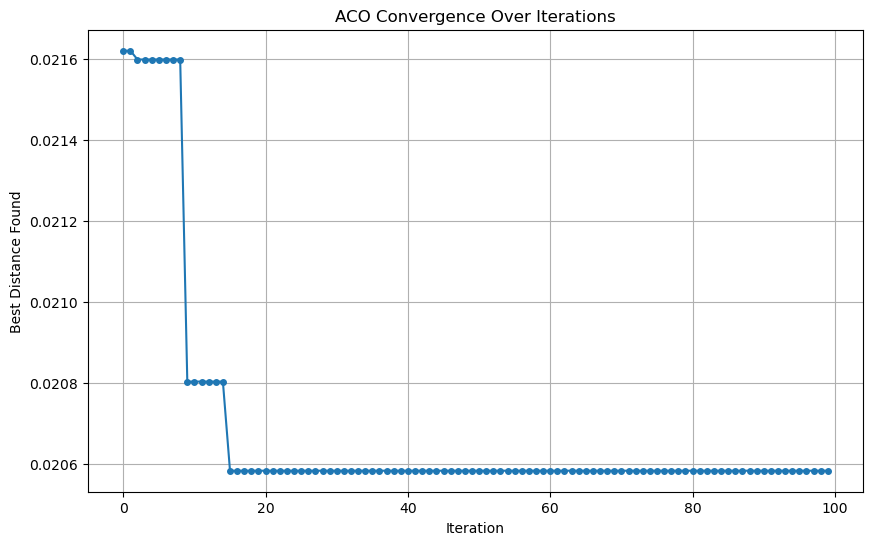

In [19]:
# Configuration
FILE_PATH = '../datasets/delivery_sh.csv'
COURIER_ID = 1061
DAY_ID = 621
GRID_SEARCH = False
best_params_config = {}

delivery_points = load_and_filter_data(FILE_PATH, COURIER_ID, DAY_ID)
if delivery_points is not None and len(delivery_points) > 1:
    depot = np.mean(delivery_points, axis=0)
    all_points = np.vstack([depot, delivery_points])
    distance_matrix = calculate_distance_matrix(all_points)

    if GRID_SEARCH:
        print("Brute Force Grid Search")
        best_params_config, all_results = perform_grid_search(distance_matrix)

        print("\n--- Grid Search Complete ---")
        print(f"Best parameters found: {best_params_config['params']}")
        print(f"Resulting in a distance of: {best_params_config['distance']:.2f}")
    else:
        print("Skipping Grid Search")
        best_params_config['params'] = {
            'n_ants': 20,
            'n_iterations': 100,
            'decay': 0.9,
            'alpha': 1,
            'beta': 3
        }

    print("\nRunning ACO with optimal parameters to generate final route and visualizations...")
    best_params = best_params_config['params']
    final_path, final_dist, final_history = run_aco_with_history(
        distances=distance_matrix,
        n_ants=best_params['n_ants'],
        n_iterations=best_params['n_iterations'],
        decay=best_params['decay'],
        alpha=best_params['alpha'],
        beta=best_params['beta']
    )
    print(f"Total Distance: {final_dist:.4f}")
    print("\nDisplaying visualizations...")

    plot_convergence(final_history)

    fig = plot_route_plotly(all_points, final_path)
    fig.show()
    fig.write_html("optimized_route_ant.html")